In [ ]:
pip install -U albumentations

     |████████████████████████████████| 102 kB 4.3 MB/s 
     |████████████████████████████████| 47.8 MB 82 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [ ]:
import os 
import torch
import cv2
import matplotlib.pyplot as plt
import glob
from torch.utils.data import DataLoader
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

Put bbox info in list of lists
make a label class id list 
make them tensor
https://pytorch.org/docs/stable/data.html

# Record the meeting

# Record the meeting


# Record the meeting


# Record the meeting

# Record the meeting

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/PSHS_Projects/crop_and_weed.zip","r") as zip_ref:
    zip_ref.extractall()

# Structure the data so that it can fed to the neural network

In [ ]:
# Pil Image: 
from PIL import Image
img = Image.open("/content/download (1).jpeg").convert("RGB")

img = cv2.imread("/content/download (1).jpeg")

# How to do we extract bboxes from files

In [ ]:
images = sorted(glob.glob("/content/agri_data/data/*.jpeg"))
text = sorted(glob.glob("/content/agri_data/data/*.txt"))
classes = ['crop', 'weed'] # Crop is labeled 0 

def yolo2voc(yolo_bbox): 

  pascal_voc_bbox = [0, 0, 0, 0]
  pascal_voc_bbox[0] = (yolo_bbox[0] - yolo_bbox[2]/2) * 512
  pascal_voc_bbox[1] = (yolo_bbox[1] - yolo_bbox[3]/2) *512
  pascal_voc_bbox[2] = (yolo_bbox[0] + yolo_bbox[2]/2) *512
  pascal_voc_bbox[3] = (yolo_bbox[1] + yolo_bbox[3]/2) * 512

  return pascal_voc_bbox


class LoadAgriData(): 

  def __init__(self, full_images, full_text, transforms): 
    self.full_images = full_images
    self.full_text = full_text
    self.transforms = transforms
    
  def __getitem__(self, x): 
    image_file = self.full_images[x] 
    text_file = self.full_text[x]
    image_id = x 

    img = cv2.imread(image_file)
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes = []
    labels = []

    # Extract numbers from text file 
    with open(text_file) as f:
      lines = f.readlines()
      for bbox in lines: 
        lines_split = bbox.split()
        lines_split = [float(value) for value in lines_split]
        yolo_voc = lines_split[1:]
        label = lines_split[0]
        pascal_voc_bboxes = yolo2voc(yolo_voc)
        boxes.append(pascal_voc_bboxes)
        labels.append(label)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id

    
    # This is where we have to use the output of get_tranforms to alter the image
    #Query about transforms for labels of images
    if self.transforms: 
      sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }

      sample = self.transforms(**sample)
      img = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

    return img, target

  def __len__(self): 
    return len(self.full_images)


def get_transforms(mode): 
  if mode == "train": 

    # A.OneOf makes the transform mutually exclusive.
    transforms = A.Compose([
                            A.OneOf([ 
                              A.RandomBrightnessContrast(p = 0.35),
                              A.ColorJitter(p = 0.35)
                            ]), 
                            A.VerticalFlip(p = 0.35), 
                            A.HorizontalFlip(p = 0.35),  
                            ToTensorV2()], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    return transforms

  elif mode == "test": 
    
    transforms = A.Compose([
                            ToTensorV2()], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

    return transforms

  else: 
    raise ValueError("Please type either train or test")


# Did not implement function
def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])

  # How do you get one at once

batch_size = 8 
training_agri_data = LoadAgriData(images, text, get_transforms("train"))
testing_agri_data = LoadAgriData(images, text, get_transforms("test"))
# agri_dataloader = DataLoader(agri_data, batch_size = batch_size, shuffle = True, collate_fn = collate_fn)

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
26.00012799999999


TypeError: ignored

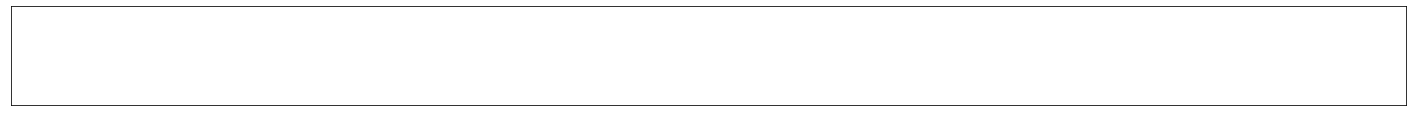

In [ ]:
agridata_iterator = iter(agri_dataloader)
img, labels = next(agridata_iterator)

def draw_boxes(boxes, labels, image):
    # read the image with OpenCV
    for i, box in enumerate(boxes):
        # (R, G, B)
        color = (255, 0, 0)
        print(box[0])
         cv.rectangle(drawing, (int(box[0]), int(box[1])), \
          (int(box[2]), int(box[3])), color, 2)
        
        cv2.putText(image, classes[labels[i - 1]], (int(box[0]), int(box[1])-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(2):
    ax = fig.add_subplot(2, 2/2, idx+1, xticks=[], yticks=[])
    img = draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx])
    plt.imshow(img)

In [ ]:
len(data[0])

8

In [ ]:
def generator(a):
  for num in a: 
    yield num + 10

a = [1, 2, 3, 4, 5]
our_generator = generator(a)


In [ ]:
our_generator

<generator object generator at 0x7f9861463cd0>

In [ ]:
iter_generator = iter(our_generator)


In [ ]:
next(iter_generator)

StopIteration: ignored

In [ ]:
agri_data = LoadAgriData(images, text)

len(agri_data)

1300

# Delete Hard coded thing

In [ ]:
building = BluePrint()

building[8]

In [ ]:
entire_data = [1, 2, 3, 4, 5, 6, 7, 8]

entire_data[0]

1

In [ ]:
class BluePrint(): 
  def __init__(self, size, color, durability, location = "Phillipines"): 
    self.color = color
    self.size = size
    self.location = location
  
  def rebuild(self): 
    print("I am going to rebuild")

  def shutdown(self, time): 
    print("Shutdown for time: {}".format(time))

  def __getitem__(self, x): 
    print(x)


In [ ]:
building = BluePrint(size = 10, color = "RED", durability = "hard")

In [ ]:
building[]

10


In [ ]:
building.location

'Phillipines'